# Chatper 15. Natural Language Processing - Pretraining

In [1]:
!pip install -U torch==2.0.0 torchvision==0.15.1
!pip install -U d2l==1.0.3

  Using cached torch-2.0.0-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchvision-0.15.1-cp310-cp310-manylinux1_x86_64.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu11-11.7.4.91-py3-none-manylinux1_x86_64.whl.m

Using cached d2l-1.0.3-py3-none-any.whl (111 kB)
Using cached matplotlib-3.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached pandas-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pandas
    Found existi

## Chapter 15.1 Word Embedding (word2vec)

* Word vectors are vectors used to represent words, and can also be considered as feature vectors or representations of words. The technique of mapping words to real vectors is called word embedding.

* The word2vec tool contains both the skip-gram and continuous bag of words models.

* The skip-gram model assumes that a word can be used to generate its surrounding words in a text sequence; while the continuous bag of words model assumes that a center word is generated based on its surrounding context words.

## Chapter 15.2 Approximate Training

* Negative sampling constructs the loss function by considering mutually independent events that involve both positive and negative examples. The computational cost for training is linearly dependent on the number of noise words at each step.

* Hierarchical softmax constructs the loss function using the path from the root node to the leaf node in the binary tree. The computational cost for training is dependent on the logarithm of the dictionary size at each step.


## Chatper 15.3 The Dataset for Pretraining Word Embeddings

In [2]:
import collections
import math
import os
import random
import torch
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', 
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    
    data_dir = d2l.download_extract('ptb')
    
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

In [4]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [6]:
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                for line in sentences]
    
    counter = collections.Counter([
        token for line in sentences for token in line
    ])
    
    num_tokens = sum(counter.values())
    
    
    # Return True if token is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) < 
              math.sqrt(1e-4 / counter[token] * num_tokens))
    
    return ([[token for token in line if keep(token)] for line in sentences], counter)

subsampled, counter = subsample(sentences, vocab)

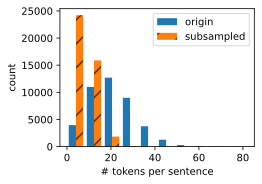

In [7]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence', 
                           'count', sentences, subsampled);

In [9]:
def compare_counts(token):
    return (f'# of "{token}": '
           f'before={sum([l.count(token) for l in sentences])}, '
           f'after={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2069'

In [10]:
compare_counts('join')

'# of "join": before=45, after=45'

In [11]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [3228, 710, 1773], [3178, 993, 3922, 1922, 4743, 2696]]

In [12]:
# Extracting Center Words and Contxt Words

In [13]:
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-garm."""
    
    centers, contexts = [], []
    for line in corpus:
        
        if len(line) < 2:
            continue
        centers += line
    
        for i in range(len(line)):
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size), 
                            min(len(line), i + 1 + window_size)))
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts


In [14]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2]
center 2 has contexts [1, 3]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [3, 4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In [15]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1501554'

In [18]:
# 15.3.4 Negative Sampling

class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    
    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        
    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        
        return self.candidates[self.i - 1]

In [19]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[1, 2, 1, 3, 3, 3, 1, 3, 2, 3]

In [20]:
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                           for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            if neg not in contexts:
                negatives.append(neg)
                
        all_negatives.append(negatives)
        
    return all_negatives

In [23]:
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(contexts_negatives),
           torch.tensor(masks), torch.tensor(labels))

In [24]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']

for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [26]:
# put it all together

def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)
    
    
    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
            
        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index], self.negatives[index])
        
        def __len__(self):
            return len(self.centers)
        
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, 
                                            collate_fn=batchify,
                                           num_workers=num_workers)
    
    return data_iter, vocab

In [27]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
        
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


* High-frequency words may not be so useful in training. We can subsample them for speedup in training.
* For computational efficiency, we load examples in minibatches. We can define other variables to distinguish paddings from non-paddings, and positive examples from negative ones.

## Chapter 15.4 Pretraining word2vec

In [28]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [29]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

In [30]:
# The Skip-Gram Model

In [32]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
     f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [33]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[ 1.1282, -0.2104, -1.3216,  0.4277],
         [-1.3235, -0.4826, -0.2026,  1.0852],
         [-0.0623,  1.4778, -0.1673, -0.7602]],

        [[ 0.0686,  1.2438,  0.6493,  0.2997],
         [ 1.0367, -0.1361, -0.3252,  0.7635],
         [-1.7689, -0.3485,  1.0522, -0.1217]]], grad_fn=<EmbeddingBackward0>)

In [34]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [35]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [36]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        
        return out.mean(dim=1)
    
loss = SigmoidBCELoss()

In [37]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [39]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [40]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                embedding_dim=embed_size),
                   nn.Embedding(num_embeddings=len(vocab),
                               embedding_dim=embed_size))

In [45]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])
    
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch
            ]
            
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask) / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
         f'{metric[1] / timer.stop():.1f} tokens/sec on {str(deivce)}')

NameError: name 'deivce' is not defined

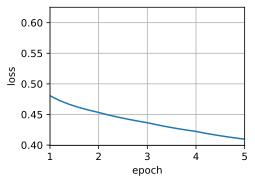

In [46]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [47]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    
    for i in topk[1:]:
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')
        
get_similar_tokens('chip', 3, net[0])

cosine sim=0.692: microprocessor
cosine sim=0.650: intel
cosine sim=0.594: chips


* We can train a skip-gram model with negative sampling using embedding layers and the binary cross-entropy loss.

* Applications of word embeddings include finding semantically similar words for a given word based on the cosine similarity of word vectors.

## Chapter 15.5 Word Embedding with Global Vectors(GloVe)

* The skip-gram model can be interpreted using global corpus statistics such as word-word co-occurrence counts.

* The cross-entropy loss may not be a good choice for measuring the difference of two probability distributions, especially for a large corpus. GloVe uses squared loss to fit precomputed global corpus statistics.

* The center word vector and the context word vector are mathematically equivalent for any word in GloVe.

* GloVe can be interpreted from the ratio of word-word co-occurrence probabilities.

## Chapter 15.6 Subword Embedding

In [48]:
import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
          '_', '[UNK]']

In [49]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}

for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
    
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

In [50]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # Key of 'pairs' is a tuple of two consecutive symbols
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get)

In [51]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair), ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
        
    return new_token_freqs

In [52]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'merge #{i + 1}:', max_freq_pair)

merge #1: ('t', 'a')
merge #2: ('ta', 'l')
merge #3: ('tal', 'l')
merge #4: ('f', 'a')
merge #5: ('fa', 's')
merge #6: ('fas', 't')
merge #7: ('e', 'r')
merge #8: ('er', '_')
merge #9: ('tall', '_')
merge #10: ('fast', '_')


In [53]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


In [54]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


In [55]:
def segment_BPE(tokens, symbols):
    outputs = []
    
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
                
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In [56]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


* The fastText model proposes a subword embedding approach. Based on the skip-gram model in word2vec, it represents a center word as the sum of its subword vectors.

* Byte pair encoding performs a statistical analysis of the training dataset to discover common symbols within a word. As a greedy approach, byte pair encoding iteratively merges the most frequent pair of consecutive symbols.

* Subword embedding may improve the quality of representations of rare words and out-of-dictionary words.

## Chapter 15.7 Word Similarity and Analogy

In [58]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [60]:
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip', 
                               '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip', 
                                'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                 'b5116e234e9eb9076672cfeabf5469f3eec904fa')

d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                          'c1816da3821ae9f43899be655002f6c723e91b88')

In [61]:
class TokenEmbedding:
    """Token Embedding."""
    
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        
    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)
    
    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                  for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs
    
    def __len__(self):
        return len(self.idx_to_token)

In [62]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

In [63]:
len(glove_6b50d)

400001

In [64]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

In [65]:
# Word Similarity

def knn(W, x, k):
    
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    
    _, topk = torch.topk(cos, k=k)
    
    return topk, [cos[int(i)] for i in topk]

In [66]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

In [67]:
get_similar_tokens('chip', 3, glove_6b50d)

cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics


In [71]:
get_similar_tokens('baby', 3, glove_6b50d)

cosine sim=0.839: babies
cosine sim=0.800: boy
cosine sim=0.792: girl


In [74]:
# Word Analogy

def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]

In [75]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

In [76]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

In [77]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

In [78]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

* In practice, word vectors that are pretrained on large corpora can be applied to downstream natural language processing tasks.

* Pretrained word vectors can be applied to the word similarity and analogy tasks.

## Chapter 15.8 Bidirectional Encoder Representations from Transformers (BERT)

In [79]:
import torch
from torch import nn
from d2l import torch as d2l

In [81]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    
    tokens = ['<cls'] + tokens_a + ['<sep>']
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments


In [85]:
class BERTEncoder(nn.Module):
    """BERT encoder."""
    
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, 
                 num_heads, num_blks, dropout, max_len=1000, **kwargs):
        
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f'{i}', d2l.TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
            
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))
            
    def forward(self, tokens, segments, valid_lens):
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [90]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)

In [91]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

In [99]:
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                nn.ReLU(),
                                nn.LayerNorm(num_hiddens),
                                nn.LazyLinear(vocab_size))
    
    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [100]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [101]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

In [102]:
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)
        
    def forward(self, X):
        return self.output(X)

In [103]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [104]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

In [105]:
class BERTModel(nn.Module):
    """The BERT Model."""
    
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                  num_heads, num_blks, dropout, max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens), nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()
        
    
    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

* BERT combines the best of both worlds: it encodes context bidirectionally and requires minimal architecture changes for a wide range of natural language processing tasks.

* The embeddings of the BERT input sequence are the sum of the token embeddings, segment embeddings, and positional embeddings.

* Pretraining BERT is composed of two tasks: masked language modeling and next sentence prediction. The former is able to encode bidirectional context for representing words, while the latter explicitly models the logical relationship between text pairs.

## Chapter 15.9 The Dataset for Pretraining BERT

In [118]:
import os
import random
import torch
from d2l import torch as d2l

In [142]:
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe'
)

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
        
    paragraphs = [line.strip().lower().split(' . ')
                 for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [120]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
        
    return sentence, next_sentence, is_next

In [121]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
        
    return nsp_data_from_paragraph

In [122]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab):
    # For the input of a masked language model, make a new copy of tokens and 
    # replace some of them by '<mask>' or random tokens.
    
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
                
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    
    return mlm_input_tokens, pred_positions_and_labels

In [123]:
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    
    for i, token in enumerate(tokens):
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
        
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]


In [124]:
# 15.9.2 Transforming Text into the Pretraining Dataset

def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens, = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    
    for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)), dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_labels_ids + [0] * (
            max_mum_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
        
    return (all_token_ids, all_segments, valid_lens, all_pred_positions, 
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [125]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs 
                    for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'
        ])
        
        examples = []
        
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
            
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                    + (segments, is_next)) for tokens, segments, is_next in examples]
        
        (self.all_token_ids, self.all_segments, self.valid_lens, 
        self.all_pred_positions, self.all_mlm_weights,
        self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)
        
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
               self.valid_lens[idx], self.all_pred_positions[idx],
               self.all_mlm_weights[idx], self.all_mlm_labels[idx],
               self.nsp_labels[idx])
    
    def __len__(self):
        return len(self.all_token_ids)

In [126]:
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
    
    return train_iter, train_set.vocab

In [141]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segements_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
         pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape, nsp_y.shape)
    break

BadZipFile: File is not a zip file

In [137]:
len(vocab)

6719

## Chapter 15.10 Pretraining BERT

In [138]:
import torch
from torch import nn
from d2l import torch as d2l

In [149]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

BadZipFile: File is not a zip file

In [144]:
net = d2l.BERTModel(len(vocab), num_hiddens=128,
                   ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [146]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                        segments_X, valid_lens_x,
                        pred_positions_X, mlm_weights_X,
                        mlm_Y, nsp_y):
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_x,
                                 valid_lens_x.reshape(-1),
                                 pred_positions_X)
    
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [147]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                           xlim=[1, num_steps], legend=['mlm', 'nsp'])
    
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, \
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                        (metric[0] / metric[3], metric[1] / metric[3]))
            
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break
    
    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
         f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentences pairs/sec on '
         f'{str(devices)}')

In [148]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

NameError: name 'train_iter' is not defined

In [152]:
# Representing Text with BERT

def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [153]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)

encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text_shape, encoded_text_cls.shapre, encoded_text_crate[0][:3]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [154]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

* The original BERT has two versions, where the base model has 110 million parameters and the large model has 340 million parameters.

* After pretraining BERT, we can use it to represent single text, text pairs, or any token in them.

* In the experiment, the same token has different BERT representation when their contexts are different. This supports that BERT representations are context-sensitive.